In [1]:
import math
import logging
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from scripts.src.hierarchy import *
from scripts.src.processing import *
from scripts.src.label_utils import *
from scripts.src.data_reading import *

logging.basicConfig(level=logging.INFO )

INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


In [2]:
num_gpus = torch.cuda.device_count()

In [3]:
device = torch.device("cuda" if (torch.cuda.is_available() and num_gpus > 0) else "cpu")

In [4]:
device

device(type='cpu')

In [5]:
n_components = 300

In [6]:
class DatasetIterator:
    def __init__(self, datafile, catfile, subsample):
        self.datafile = datafile
        self.cat = HierarchyUtils(catfile, False, False)
        self.wn = self.cat.generate_vectors(device = device, neighbours = True)
        self.lib_data = LIBSVM_Reader(self.datafile, True, n_components, subsample)
        self.df = self.lib_data.data_df
    
    def read_df(self, idx):
        i = self.df.index[self.df["doc_id"] == idx][0]
        return self.df.at[i, "doc_vector"], self.df.at[i, "doc_labels"], i

    def __getitem__(self, _id):
        return self.read_df(_id)

    def __iter__(self):
        for _id in self.df["doc_id"]:
            yield self[_id]

class DatasetModule(Dataset):

    def __init__(self, root_location, cat_file, subsample):
        self.iter = DatasetIterator(root_location, cat_file, subsample)
        self.lmbda = self.lambda_param()
        
    def lambda_param(self):
        w_n = list2tensor(self.iter.wn[0].values())
        w_pi = list2tensor(self.iter.wn[1].values())

        norm2 = torch.norm(w_n-w_pi, 2)
        lmbda = 0.5*norm2**2
        return lmbda

    def encode_labels(self, labels):
        yin = torch.ones(len(self.iter.cat.node2id), dtype=torch.float32)*-1
        y_in = []
        label_vector = []
        for l in labels:
            yin[self.iter.cat.node2id[l]] = 1.
            if l in self.iter.cat.T_leaves:
                indicator = torch.Tensor([1])
            else:
                indicator = torch.Tensor([-1])
            y_in.append(indicator)
            label_vector.append(self.iter.wn[0][l])
#         label_vector = label_vector/len(labels)
        return label_vector, y_in

    def __len__(self):
        return len(self.iter.df["doc_id"])

    def __load(self, idx):
        doc_vec, doc_labels, _id = self.iter[idx]
        return doc_vec, doc_labels, _id, self.encode_labels(doc_labels)

    def __getitem__(self, idx):
        return self.__load(idx)

In [7]:
train_data = DatasetModule("rcv1.tar/RCV1_1/rcv1.train.ltc.svm", "rcv1.tar/RCV1_1/rcv1.topic.hierarchy", 1)

35it [00:00, 69805.34it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 332.43it/s]
1157it [00:00, 27585.95it/s]
100%|███████████████████████████████████████████████████████████████████████████| 1157/1157 [00:00<00:00, 32954.92it/s]


In [8]:
batch_size = 1

In [9]:
train_loader = DataLoader(train_data, shuffle = True, pin_memory=True, batch_size=batch_size)
# valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle = False)

In [10]:
train_iter = iter(train_loader)
doc_vec, doc_labels, _id, wn =  train_iter.next()

In [11]:
print(doc_vec.shape)
print("*"*50)
print(wn[0][0].shape)
print("-"*50)
print(wn[1][0])
print("_"*50)

torch.Size([1, 300])
**************************************************
torch.Size([1, 117, 1])
--------------------------------------------------
tensor([[-1.]])
__________________________________________________


In [12]:
torch.version.cuda

In [13]:
torch.backends.cudnn.version()

In [14]:
torch.backends.cudnn.benchmark = True

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score

def gather_outputs(data, model):
    y_true = []
    y_pred = []
    logging.info("Evaluating ...")
    with torch.no_grad():
        for index, (doc_vec, doc_labels, _id, label_vecs) in enumerate(data):
            
            seq = doc_vec
            print(seq)
            label_vec = label_vecs[0].squeeze()
            yin = label_vecs[1]
            output = model(seq, label_vec, yin)
            
            print(output)

            threshold = torch.mean(output).item()
#             threshold = 0.5

            output[output >= threshold] = 1
            output[output < threshold] = -1
            
            y_pred.append(output.cpu().view(-1).numpy())
            y_true.append(yin.numpy())
            
            if (index+1) % 500 == 0:
                print(output, yin)
                test_f1 = f1_score(np.asarray(y_true), np.array(y_pred), average="micro")
                print("Index: {}/{} F1: {}".format(index+1, len(data), test_f1))
    
    y_true = np.asarray(y_true)
    y_pred = np.array(y_pred)
    test_f1 = f1_score(y_true, y_pred, average="micro")
    return y_true, y_pred

In [16]:
class Node(nn.Module):
    def __init__(self, weight_dims):
        super().__init__()
        weights = torch.FloatTensor(*weight_dims)
        weights = nn.init.xavier_uniform_(weights)
        self.w = nn.Parameter(weights)    
        
    def forward(self, x_i):
        return x_i.matmul(self.w)

    
class HRLR(nn.Module):
    def __init__(self, input_dim, n_classes):
        super().__init__()
        self.linear = Node([input_dim, n_classes])
        self.linear2 = Node([n_classes, 1])
#         self.all_nodes = []
#         self.leaf_nodes = []
        
        
#         self.all_nodes.append(Node(input_dim, n_classes))
        # loop through the graph structure and create the classifier structure
        # store all of it all_nodes, but store references for all of the leaf nodes in the leaf nodes list
    
    def forward(self, x_i, w_n):
        # for each node, compute forward, and do a -1 +1 threshold to get classes
        x_i = self.linear(x_i)
        self.fwd_pass = (x_i)*w_n
        
        return self.fwd_pass
    
    def compute_loss_leaf(self, yin):
        loss = torch.log1p(torch.exp(-yin *self.fwd_pass))
        return loss
    
    def compute_loss_non_leaf(self, yin):
        loss = 1 - yin*self.fwd_pass
        return torch.mean(loss)

In [46]:
x_i = torch.rand(300,) #doc vec
w_n = torch.FloatTensor(3,)
yin = torch.Tensor([-1, 1, -1])

linear = Node([300, 117])
lin = Node([117, 1])
linear(x_i) #pass doc vec to node nn

tensor([-0.3556,  0.3884,  0.1371, -0.1389,  0.7216,  1.2512,  1.4120,  0.1044,
         0.4370, -1.6375,  0.1126, -0.0317,  0.3667,  0.0707, -0.8993,  0.2248,
         0.2193, -0.4157, -0.4864,  0.6615,  0.4523,  0.1966, -0.1696, -0.6285,
        -0.2683, -0.9878, -0.5152, -0.0196,  0.7373,  0.8922,  1.0400,  0.2518,
         0.1831,  1.1204,  0.4340,  0.6054, -0.3266, -0.0249,  0.8212, -0.3411,
         0.2321, -0.8666,  0.5052, -0.1058, -0.0667, -0.2336,  0.3096,  0.4164,
        -0.7387,  0.9758,  1.2439, -0.2728,  0.7941, -0.3048, -1.8721,  0.5797,
         0.4761,  0.4195, -0.8803,  0.4809,  0.3571,  0.2510, -2.0544,  0.0513,
        -0.3072, -1.2391,  0.7394,  0.0330,  0.4287, -0.2258,  0.5285, -0.7058,
         0.0596,  0.5355, -0.6405,  0.4584, -0.2550,  0.1812,  0.5672, -0.5959,
         0.4224, -0.2579,  0.1563, -0.2494, -0.6159,  0.0459, -0.0295, -0.4158,
         1.4801,  0.5479,  0.3834, -0.4931, -0.4449,  0.6343,  1.0761, -0.8354,
         0.2257, -0.1109, -0.0970, -0.12

In [47]:
(-linear(doc_vec)*(label_vec[0])).shape

torch.Size([1, 117, 117])

In [48]:
print((torch.log1p(torch.exp(-linear(doc_vec)*(label_vec[0])*wn[1][0]))))

tensor([[[0.6941, 0.6952, 0.6911,  ..., 0.6967, 0.6949, 0.6920],
         [0.6929, 0.6926, 0.6936,  ..., 0.6923, 0.6927, 0.6934],
         [0.6932, 0.6932, 0.6931,  ..., 0.6932, 0.6932, 0.6931],
         ...,
         [0.6923, 0.6913, 0.6949,  ..., 0.6900, 0.6916, 0.6942],
         [0.6925, 0.6917, 0.6945,  ..., 0.6907, 0.6919, 0.6940],
         [0.6940, 0.6949, 0.6915,  ..., 0.6961, 0.6946, 0.6922]]],
       grad_fn=<Log1PBackward>)


In [49]:
lrr = HRLR(n_components, num_classes)

In [50]:
lrr.forward(doc_vec, wn[0][0].squeeze())

tensor([[-2.7286e-04, -5.8906e-04, -1.2482e-04, -3.4745e-03, -2.6662e-03,
         -1.9736e-03, -6.3880e-04, -6.6700e-08, -9.8846e-04,  1.5042e-04,
         -2.9052e-03,  1.7922e-03, -7.8385e-04,  5.2867e-04,  5.0290e-05,
          6.9366e-05, -2.2596e-03, -5.3449e-03,  2.2916e-03,  2.6406e-04,
          4.8162e-04, -3.4864e-04, -3.9629e-03, -2.0648e-03,  4.5326e-03,
          6.8529e-03,  8.1558e-04,  1.3225e-04, -9.3767e-04, -4.2121e-04,
         -3.0751e-04, -1.6425e-03,  2.7530e-04, -7.4484e-03,  2.6502e-04,
          3.9637e-04,  1.5146e-03, -3.9889e-03, -5.0928e-03, -3.2761e-03,
          1.9460e-03, -1.8938e-03,  1.6054e-03, -2.9268e-03,  4.4918e-03,
         -2.9239e-03, -4.3428e-03,  9.2111e-04, -1.7196e-03,  3.2554e-03,
          3.5910e-03, -4.0279e-03, -9.3613e-03, -4.6862e-04,  5.1331e-03,
          2.7828e-03, -2.5167e-04, -1.2669e-03, -2.1076e-03,  1.3230e-03,
         -4.0168e-03,  3.2876e-03,  7.1112e-03,  1.5776e-04, -7.9771e-04,
         -2.8265e-03,  3.5170e-03,  4.

In [51]:
lrr.compute_loss_leaf(wn[1][0])

tensor([[0.6930, 0.6929, 0.6931, 0.6914, 0.6918, 0.6922, 0.6928, 0.6931, 0.6927,
         0.6932, 0.6917, 0.6940, 0.6928, 0.6934, 0.6932, 0.6932, 0.6920, 0.6905,
         0.6943, 0.6933, 0.6934, 0.6930, 0.6912, 0.6921, 0.6954, 0.6966, 0.6936,
         0.6932, 0.6927, 0.6929, 0.6930, 0.6923, 0.6933, 0.6894, 0.6933, 0.6933,
         0.6939, 0.6912, 0.6906, 0.6915, 0.6941, 0.6922, 0.6940, 0.6917, 0.6954,
         0.6917, 0.6910, 0.6936, 0.6923, 0.6948, 0.6949, 0.6911, 0.6885, 0.6929,
         0.6957, 0.6945, 0.6930, 0.6925, 0.6921, 0.6938, 0.6911, 0.6948, 0.6967,
         0.6932, 0.6927, 0.6917, 0.6949, 0.6954, 0.6974, 0.6933, 0.6897, 0.6923,
         0.6924, 0.6957, 0.6930, 0.6956, 0.6987, 0.6996, 0.6926, 0.6939, 0.6930,
         0.6939, 0.6932, 0.6916, 0.6929, 0.6883, 0.6915, 0.6936, 0.6968, 0.6932,
         0.6927, 0.6915, 0.6927, 0.6943, 0.6963, 0.6894, 0.6943, 0.6928, 0.6952,
         0.6949, 0.6929, 0.6923, 0.6925, 0.6979, 0.6936, 0.6932, 0.6951, 0.6899,
         0.6941, 0.6936, 0.6

In [52]:
x_i.matmul(linear.w.data).size()

torch.Size([117])

In [53]:
linear.w.size()

torch.Size([300, 117])

In [54]:
# Model
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, num_classes, False)
        self.exp = torch.exp
        
    def forward(self, x, labels, yin):
        x1 = self.linear1(x)
        y  = x1.mul(labels)
        exp_ = self.exp(-y*yin)
        return torch.log(1+exp_)

In [112]:
# Hyper Parameters 
input_size = n_components #128 n_components
# input_size = train_data.data[0].shape[1] #2085164 

num_classes = len(train_data.iter.cat.N_all_nodes) #50312 --> n (16)
num_epochs = 5 # TRAIN IT FOR A LOT OF EPOCHS in case of lbfgs (2nd order method) else less is more
learning_rate = 0.0005 #1e-4, 0.0005

model = HRLR(n_components, num_classes)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=train_data.lmbda)
# optimizer = torch.optim.LBFGS(model.parameters(), lr=learning_rate)

In [113]:
train_data.lmbda

tensor(0.2389)

In [114]:
total_step = len(train_loader)

In [115]:
total_step

1157

In [116]:
torch.cuda.empty_cache()

In [117]:
import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
monitor = {
    "test_f1": [],
    "loss": []
}

In [119]:
for epoch in range(num_epochs):
    for doc_vec, doc_labels, _id, label_vecs in tqdm(train_loader):
        label_vec = label_vecs[0]
        yin = label_vecs[1]
        for i, each_label_vec in enumerate(label_vec):
            optimizer.zero_grad()
            output = model.forward(doc_vec, each_label_vec.squeeze())
            loss = model.compute_loss_leaf(yin[i]) 
            loss.mean().backward()
            optimizer.step()
        monitor["loss"].append((loss.mean().item()))
#         loss_per+=loss.item()
#             else:
#                 label_vec = label_vecs[0].squeeze()
#                 yin = label_vecs[1].squeeze()
                
#                 model.zero_grad()
                
#                 output = model.forward(doc_vec, label_vec)

#                 loss = model.compute_loss_non_leaf(yin) 
#                 loss.backward()

#                 optimizer.step()
                
#                 loss_per += loss.item()
            


100%|█████████████████████████████████████████████████████████████████████████████| 1157/1157 [00:05<00:00, 201.59it/s]


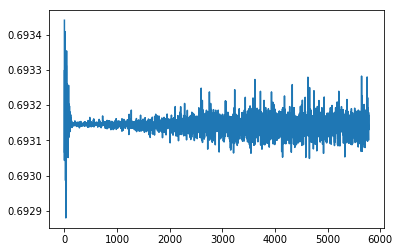

In [120]:
plt.plot(monitor["loss"]);

In [93]:
monitor["loss"]

[0.6929802894592285,
 0.6930485963821411,
 0.693127453327179,
 0.6931055188179016,
 0.6929110884666443,
 0.6930413246154785,
 0.6930298805236816,
 0.6932344436645508,
 0.6931713223457336,
 0.6930485367774963,
 0.6931593418121338,
 0.6931775808334351,
 0.69309002161026,
 0.6931564211845398,
 0.6930827498435974,
 0.6931803822517395,
 0.6931025981903076,
 0.6931264400482178,
 0.6931087374687195,
 0.6931004524230957,
 0.6931522488594055,
 0.6931512355804443,
 0.6931491494178772,
 0.6931407451629639,
 0.6931425929069519,
 0.6931487321853638,
 0.6931255459785461,
 0.6931558847427368,
 0.6931547522544861,
 0.6931408643722534,
 0.6931384205818176,
 0.6931542754173279,
 0.6931434273719788,
 0.6931484937667847,
 0.6931480169296265,
 0.6931470632553101,
 0.6931478977203369,
 0.6931471824645996,
 0.6931461691856384,
 0.693148136138916,
 0.6931460499763489,
 0.6931480765342712,
 0.6931378841400146,
 0.6931470036506653,
 0.6931563019752502,
 0.6931450963020325,
 0.6931445598602295,
 0.69314312934875

In [ ]:
doc_vec*label_vec

In [ ]:
y_true, y_pred = gather_outputs(test_data, model)
test_f1 = f1_score(y_true, y_pred, average="micro")
logging.info("Test F1: {}".format(test_f1))
monitor["test_f1"].append(test_f1)

In [ ]:
plt.plot(monitor["test_f1"]);